In [1]:
from slim_gsgp_lib_np.main_slim import slim
from slim_gsgp_lib_np.utils.utils import train_test_split
from slim_gsgp_lib_np.utils.callbacks import *
from slim_gsgp_lib_np.evaluators.fitness_functions import rmse
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import time
import os
from tqdm import tqdm
from functions.test_funcs import mape, nrmse, r_squared, mae, standardized_rmse
from matplotlib import pyplot as plt
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.mutators import *
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.simplifiers import *
from slim_gsgp_lib_np.datasets.data_loader import *
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from slim_gsgp_lib_np.selection.selection_algorithms import tournament_selection_min
from datasets_multislim.synthetic_datasets import * 

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"

from slim_gsgp_lib_np.main_gp import gp
# from slim_gsgp_lib_np.algorithms.GP.representations.tree import Tree

# -------------------------- # 
from slim_gsgp_lib_np.utils.utils import check_slim_version
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.tree import Tree
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition import Condition
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.population import Population    
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.tree_utils import *
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.operators.mutators import *
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.operators.xo import *
from slim_gsgp_lib_np.config.multi_slim_config import SlimParameters, GPParameters
from slim_gsgp_lib_np.main_multi_slim import multi_slim 
from slim_gsgp_lib_np.algorithms.GP.representations.tree import Tree as GP_Tree
from IPython.display import clear_output


In [2]:
from slim_gsgp_lib_np.utils.callbacks import SLIM_GSGP_Callback
from collections import defaultdict
from itertools import chain
import itertools
import numpy as np
from scipy.optimize import linear_sum_assignment

class LogSpecialist(SLIM_GSGP_Callback):
    def __init__(self, masks, X_train, y_train):
        self.log = []
        self.count_specialists = []
        self.masks = masks 
        self.X_train = X_train
        self.y_train = y_train

    def on_generation_start(self, optimizer, generation):     
        if not generation % 10 == 0:
            return 

        mins = [1e10] * len(self.masks)
        best = [None] * len(self.masks)
        counts = [0] * len(self.masks)
        for ind in optimizer.population:
            for i, mask in enumerate(self.masks):
                preds = ind.predict(self.X_train[mask])
                fitness = rmse(self.y_train[mask], preds)
                if fitness < mins[i]:
                    mins[i] = fitness
                    best[i] = ind
                    counts[i] = 1
                elif fitness == mins[i]:
                    counts[i] += 1
        self.log.append(mins)
        self.count_specialists.append(counts)

    def plot_specialist_fitnesses(self):
        fig, ax = plt.subplots()
        ax.plot(self.log)
        ax.set_xlabel('Generation')
        ax.set_ylabel('RMSE')
        ax.set_title('Fitness of Specialists')
        ax.legend([f'Specialist {i+1}' for i in range(len(self.masks))])
        plt.show()

def get_specialist_masks(tree_node, X_data, current_mask=None):

    """
    Function used to get the masks for each specialist to be used for specialist tunning

    Write the rest of the documentation 

    """
    def recursion(tree_node, X_data, current_mask=None):
        if current_mask is None:
            current_mask = np.ones(X_data.shape[0], dtype=bool)
        
        if isinstance(tree_node, tuple):  # Condition node
            condition = tree_node[0]
            left_child = tree_node[1]
            right_child = tree_node[2]
            
            # Evaluate condition
            cond_results = condition.predict(X_data) > 0
            true_mask = current_mask & cond_results
            false_mask = current_mask & ~cond_results
            
            # Process both branches
            left_masks = recursion(left_child, X_data, true_mask)
            right_masks = recursion(right_child, X_data, false_mask)
            
            # Merge results while preserving all masks
            merged = defaultdict(list)
            for sp, masks in chain(left_masks.items(), right_masks.items()):
                merged[sp].extend(masks)
                
            return merged
            
        else:  # Specialist node (leaf)
            return {tree_node: [current_mask]}
    
    result = recursion(tree_node, X_data)
    merged = defaultdict(list)

    for ind, mask in result.items(): 
        merged[ind] = np.sum(mask, axis=0).astype(bool)

    return merged    

def calculate_specialist_rmse(ensemble_tree, X_train, y_train):
    """
    Calculates RMSE for each specialist on samples where their decision paths activate
    
    Parameters:
    ensemble_tree: The trained ensemble tree structure
    X_train (array-like): Training features
    y_train (array-like): True target values
    specialists (dict): Dictionary of specialist objects
    
    Returns:
    dict: Specialist IDs mapped to their path-specific RMSE scores
    """
    # Get all activation masks
    masks = get_specialist_masks(ensemble_tree.collection, X_train)
    specialists = ensemble_tree.SPECIALISTS
    
    # Calculate RMSE for each specialist
    rmse_scores = {}
    
    for sp_id, mask_list in masks.items():
        if sp_id not in specialists:
            continue
            
        # Combine all paths for this specialist
        combined_mask = mask_list
        n_samples = np.sum(combined_mask)
        
        if n_samples == 0:
            rmse_scores[sp_id] = (0, np.nan)
            continue
            
        # Get predictions for active samples
        X_active = X_train[combined_mask]
        y_true = y_train[combined_mask]
        y_pred = specialists[sp_id].predict(X_active)
        
        # Calculate RMSE
        error = y_true - y_pred
        rmse_value = np.sqrt(np.mean(error**2))
        rmse_scores[sp_id] = (n_samples, rmse_value)
    
    return rmse_scores

def normalized_hamming_distance(mask1, mask2):
    """
    Compute the normalized Hamming distance between two boolean masks.
    The masks must be 1D numpy arrays of the same length.
    """
    return np.sum(mask1 != mask2) / mask1.size

def compute_composite_mask_distance(ground_truth_masks, predicted_masks, lambda_penalty=0.5):
    """
    Compute a composite distance between two sets of masks.
    
    ground_truth_masks and predicted_masks are lists (or arrays) of boolean masks.
    The distance is computed as the average normalized Hamming distance for the optimal 
    matching (using the Hungarian algorithm) plus a penalty for the difference in the number 
    of masks.
    
    Parameters:
      ground_truth_masks: list of 1D numpy boolean arrays (ground truth)
      predicted_masks: list of 1D numpy boolean arrays (predicted from the model)
      lambda_penalty: penalty weight for each extra/missing mask.
      
    Returns:
      composite_distance: the computed composite distance.
    """
    n_gt = len(ground_truth_masks)
    n_pred = len(predicted_masks)
    
    # Create cost matrix for the pairwise distances
    cost_matrix = np.zeros((n_gt, n_pred))
    for i, gt_mask in enumerate(ground_truth_masks):
        for j, pred_mask in enumerate(predicted_masks):
            cost_matrix[i, j] = normalized_hamming_distance(gt_mask, pred_mask)
    
    # Solve the assignment problem for the best matching
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    total_cost = cost_matrix[row_ind, col_ind].sum()
    avg_cost = total_cost / len(row_ind)
    
    # Add penalty for unmatched masks (if the numbers differ)
    unmatched = abs(n_gt - n_pred)
    composite_distance = avg_cost + lambda_penalty * unmatched
        
    return composite_distance

def compute_split_distance(gt_masks, pred_masks):
    """
    Compute the minimum distance between a predicted binary split (2 masks)
    and a multi-case ground truth by considering all ways to merge the ground
    truth masks into 2 clusters.
    """
    if type(pred_masks) != defaultdict:
        print('Warning: pred_masks is not a defaultdict')
        return None
    
    pred_masks = [value for key, value in pred_masks.items()]

    k = len(gt_masks)
    best_distance = np.inf
    best_combo = None
    
    # Enumerate all non-empty, non-full subsets up to symmetry
    for r in range(1, (k // 2) + 1):
        for combo in itertools.combinations(range(k), r):
            other = tuple(set(range(k)) - set(combo))
            
            # Avoid duplicate partitions when k is even and r == k/2
            if k % 2 == 0 and r == k // 2 and combo > other:
                continue
            
            # Aggregate masks by OR-ing within each cluster
            agg1 = np.any([gt_masks[i] for i in combo], axis=0)
            agg2 = np.any([gt_masks[i] for i in other], axis=0)
            
            # Compute distance for this partition
            dist = compute_composite_mask_distance([agg1, agg2], pred_masks, lambda_penalty=0)
            best_distance = min(best_distance, dist)
            if best_distance == dist:
                best_combo = combo
    
    return best_distance, best_combo

def compute_split_distance_general(gt_masks, pred_masks, lambda_penalty=0.5):
    """
    Compute minimum distance between predicted masks and best merge of gt_masks into n clusters,
    where n = len(pred_masks) < len(gt_masks).
    Returns (best_distance, best_partition_mapping).
    """
    # Convert pred_masks from dict to list if needed
    if isinstance(pred_masks, defaultdict) or isinstance(pred_masks, dict):
        pred_masks_list = list(pred_masks.values())
    else:
        pred_masks_list = pred_masks

    k = len(gt_masks)
    n = len(pred_masks_list)
    if n >= k:
        raise ValueError("Number of predicted clusters must be less than number of ground-truth masks.")
    
    best_distance = np.inf
    best_partition = None

    # Generate all assignments of gt indices to cluster ids [0..n-1] with each id used at least once
    for labels in itertools.product(range(n), repeat=k):
        if set(labels) != set(range(n)):
            continue  # ensure all clusters non-empty

        # Aggregate gt masks per cluster
        aggregated = []
        for cluster_id in range(n):
            indices = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
            agg_mask = np.any([gt_masks[i] for i in indices], axis=0)
            aggregated.append(agg_mask)

        # Compute distance
        dist = compute_composite_mask_distance(aggregated, pred_masks_list, lambda_penalty)
        if dist < best_distance:
            best_distance = dist
            best_partition = labels
    
    return best_distance, best_partition

In [3]:
from collections import defaultdict
from itertools import chain
from scipy.optimize import linear_sum_assignment


def get_specialist_masks(tree_node, X_data, current_mask=None):

    """
    Function used to get the masks for each specialist to be used for specialist tunning

    Write the rest of the documentation 

    """
    def recursion(tree_node, X_data, current_mask=None):
        if current_mask is None:
            current_mask = np.ones(X_data.shape[0], dtype=bool)
        
        if isinstance(tree_node, tuple):  # Condition node
            condition = tree_node[0]
            left_child = tree_node[1]
            right_child = tree_node[2]
            
            # Evaluate condition
            cond_results = condition.predict(X_data) > 0
            true_mask = current_mask & cond_results
            false_mask = current_mask & ~cond_results
            
            # Process both branches
            left_masks = recursion(left_child, X_data, true_mask)
            right_masks = recursion(right_child, X_data, false_mask)
            
            # Merge results while preserving all masks
            merged = defaultdict(list)
            for sp, masks in chain(left_masks.items(), right_masks.items()):
                merged[sp].extend(masks)
                
            return merged
            
        else:  # Specialist node (leaf)
            return {tree_node: [current_mask]}
    
    result = recursion(tree_node, X_data)
    merged = defaultdict(list)

    for ind, mask in result.items(): 
        merged[ind] = np.sum(mask, axis=0).astype(bool)

    return merged    

def calculate_specialist_rmse(ensemble_tree, X_train, y_train):
    """
    Calculates RMSE for each specialist on samples where their decision paths activate
    
    Parameters:
    ensemble_tree: The trained ensemble tree structure
    X_train (array-like): Training features
    y_train (array-like): True target values
    specialists (dict): Dictionary of specialist objects
    
    Returns:
    dict: Specialist IDs mapped to their path-specific RMSE scores
    """
    # Get all activation masks
    masks = get_specialist_masks(ensemble_tree.collection, X_train)
    specialists = ensemble_tree.SPECIALISTS
    
    # Calculate RMSE for each specialist
    rmse_scores = {}
    
    for sp_id, mask_list in masks.items():
        if sp_id not in specialists:
            continue
            
        # Combine all paths for this specialist
        combined_mask = mask_list
        n_samples = np.sum(combined_mask)
        
        if n_samples == 0:
            rmse_scores[sp_id] = (0, np.nan)
            continue
            
        # Get predictions for active samples
        X_active = X_train[combined_mask]
        y_true = y_train[combined_mask]
        y_pred = specialists[sp_id].predict(X_active)
        
        # Calculate RMSE
        error = y_true - y_pred
        rmse_value = np.sqrt(np.mean(error**2))
        rmse_scores[sp_id] = (n_samples, rmse_value)
    
    return rmse_scores


def simplify_ensemble(tree, X_data, min_usage=0.1):
    """
    Simplify an ensemble tree by iteratively pruning a single specialist branch occurrence
    whose usage (coverage) is below min_usage. The usage for each node occurrence is computed
    using its unique index path in the tuple structure.

    Tree structure:
      - A condition node is a tuple: (condition, left_child, right_child).
        Its condition is always at index 0.
      - A specialist node (leaf) is any object (e.g. a string or label).
    
    For example, for the tree: (C1, S1, (C2, S2, S4))
      - The root condition C1 is at path (0,).
      - Its left branch S1 is at path (0,1).
      - Its right child is a tuple and its condition C2 is at path (0,2,0),
        its left specialist S2 is at path (0,2,1),
        and its right specialist S4 is at path (0,2,2).

    Process per iteration:
      1) Compute usage statistics (fraction of X_data reaching each occurrence) 
         with keys given by the occurrence path.
      2) Look up among specialist occurrences (non-tuple) those with usage below min_usage.
      3) Identify the candidate with the smallest usage and prune it by its index.
         (Pruning is done by replacing its entire parent branch with its sibling.)
      4) Repeat until no specialist occurrence has usage below min_usage.

    Parameters:
      tree: The ensemble structure as nested tuples.
      X_data: numpy array of feature data (with shape [n_samples, features]).
      min_usage: Minimum usage ratio threshold (e.g. 0.1 for 10% coverage).

    Returns:
      The simplified (pruned) ensemble tree.
    """
    dataset_size = X_data.shape[0]

    # --- Step 1. Annotate every node occurrence with its usage, keyed by a path.
    def annotate_tree(node, mask, path, usage_stats):
        """
        Recursively annotate each occurrence in the tree with its usage.
        The key 'path' is a tuple of indices that uniquely identifies the occurrence.
        
        Parameters:
          node: current node (either a tuple for conditions or a specialist leaf).
          mask: a boolean array (of length n_samples) indicating which samples reach here.
          path: a tuple (e.g. (0,1) or (0,2,1)) to uniquely identify the occurrence.
          usage_stats: dictionary to update with {path: usage_ratio}.
        """
        usage_stats[path] = np.sum(mask) / dataset_size
        if isinstance(node, tuple):
            # node[0] is a condition; use it to split the data.
            condition = node[0]
            # Evaluate condition on the entire X_data (mask applies here)
            cond_results = condition.predict(X_data) > 0  # assume >0 means "True"
            true_mask = mask & cond_results
            false_mask = mask & ~cond_results
            # Left branch gets index 1, right branch gets index 2.
            annotate_tree(node[1], true_mask, path + (1,), usage_stats)
            annotate_tree(node[2], false_mask, path + (2,), usage_stats)
        # else: specialist leaf has been annotated

    # Helper: Given a tree and a path, return the node at that path.
    def get_node_at_path(tree, path):
        current = tree
        # Skip the first element in path (should be 0, the root)
        for p in path[1:]:
            if not isinstance(current, tuple):
                return current
            if p == 1:
                current = current[1]
            elif p == 2:
                current = current[2]
            else:
                raise ValueError("Path index must be 1 or 2 for children")
        return current

    # --- Step 3. Prune a node occurrence by its index (path)
    def prune_at_path(tree, target_path, current_path=(0,)):
        """
        Recursively traverse tree using current_path. When the current_path matches
        the parent of the target (i.e. current_path == target_path[:-1]), replace the branch
        corresponding to target_path[-1] with its sibling.
        
        Parameters:
          tree: current subtree.
          target_path: tuple that indicates the occurrence to prune.
          current_path: tuple indicating the current position (default is (0,) for root).
        
        Returns:
          A new tree with the branch pruned.
        """
        # Check if current_path is the parent of the target.
        if current_path == target_path[:-1]:
            # tree is a tuple: (condition, left_child, right_child)
            candidate_index = target_path[-1]
            # Replace the branch at candidate_index with the sibling.
            if candidate_index == 1:
                return tree[2]
            elif candidate_index == 2:
                return tree[1]
            else:
                raise ValueError("Invalid branch index (must be 1 or 2)")
        
        # Otherwise, only update the branch that is along the target_path.
        if isinstance(tree, tuple):
            new_condition = tree[0]
            # For each child, update only if the path is a prefix of target_path.
            new_left = tree[1]
            new_right = tree[2]
            
            # Check if target_path goes through the left child.
            if target_path[:len(current_path) + 1] == current_path + (1,):
                new_left = prune_at_path(tree[1], target_path, current_path + (1,))
            # Check if target_path goes through the right child.
            if target_path[:len(current_path) + 1] == current_path + (2,):
                new_right = prune_at_path(tree[2], target_path, current_path + (2,))
            return (new_condition, new_left, new_right)
        else:
            return tree  # specialist leaf; nothing to update

    # --- Main Iterative Loop.
    current_tree = tree
    while True:
        usage_stats = {}
        full_mask = np.ones(dataset_size, dtype=bool)
        annotate_tree(current_tree, full_mask, (0,), usage_stats)
        # --- Step 2. Look for specialist occurrences (non-tuple) with usage below threshold.
        candidate_paths = []
        for path, usage in usage_stats.items():
            # Use get_node_at_path to see if this occurrence is a specialist.
            node_occurrence = get_node_at_path(current_tree, path)
            if not isinstance(node_occurrence, tuple) and usage < min_usage:
                candidate_paths.append((path, usage))
        if not candidate_paths:
            break  # No candidate found; we are done.
        # Find the candidate with the smallest usage.
        target_path, target_usage = min(candidate_paths, key=lambda x: x[1])
        # --- Step 3. Prune that occurrence.
        current_tree = prune_at_path(current_tree, target_path)
        # Optionally: print the pruned candidate for debugging.
        # print(f"Pruned candidate at path {target_path} with usage {target_usage:.4f}")
    return current_tree

def replace_subtree(tree, path, new_subtree):
    """
    Replaces a subtree in a nested tuple using a specified path.
    Args:
        tree: The nested tuple representing the tree.
        path: A list of indices (e.g. [1, 2, 1]) leading to the parent tuple
              that should be replaced.
        new_subtree: The new subtree/value to insert at that position.
    Returns:
        A new tree with the specified replacement.
    """
    if not path:
        return new_subtree
    # Convert to a list to update and then back to tuple.
    index = path[0]
    lst = list(tree)
    lst[index] = replace_subtree(lst[index], path[1:], new_subtree)
    return tuple(lst)


def get_leaf_candidates(tree, path=None):
    """
    Recursively traverse the tree (nested tuple) and find candidate leaves
    for simplification. Candidates are the children (at index 1 or 2) in a tuple node
    which are terminal (not a tuple) and, as strings, do not end with '0'.
    
    Args:
         tree: A nested tuple.
         path: A list indicating the path to the current tree.
    Returns:
         A list of candidates. Each candidate is a tuple (parent_path, child_index, candidate_value).
    """
    if path is None:
        path = []
    
    candidates = []
    
    if isinstance(tree, tuple):
        # Expect a tuple of the form (function, left, right)
        # We assume tree[0] is a function/operator.
        op = tree[0]
        left = tree[1]
        right = tree[2]
        
        # Check left child: candidate if not a tuple and its string does not end with '0'
        if not isinstance(left, tuple) and (not str(left).endswith("0")):
            candidates.append((path, 1, left))
        
        # Check right child similarly.
        if not isinstance(right, tuple) and (not str(right).endswith("0")):
            candidates.append((path, 2, right))
        
        # Continue recursion on children that are subtrees.
        if isinstance(left, tuple):
            candidates.extend(get_leaf_candidates(left, path + [1]))
        if isinstance(right, tuple):
            candidates.extend(get_leaf_candidates(right, path + [2]))
    return candidates

def recursive_simplification(tree, threshold, X, y, verbose=False, node_possible=False, **kwargs):
    """
    Repeatedly applies simplification moves to a tree.
    
    Steps:
      1. Extract tree.repr_.
      2. Calculate candidate simplification positions (last indices).
      3. Generate all possible simplified trees.
      4. Evaluate each and choose the candidate that improves RMSE the best, if improvement > threshold.
      5. Repeat if any change is made.
    
    Args:
         tree: An object with an attribute 'repr_' holding the tree as a nested tuple.
         threshold: The minimum RMSE improvement required to accept a change.
    Returns:
         A tuple (final_tree_repr, final_rmse).
    """
    # Start from the tree representation.
    preds = tree.predict(X)
    initial_rmse = rmse(y, preds)
    current_repr = tree.repr_
    iteration = 0
    data = {'candidate': [], 'difference': [], 'it': []}

    while True:
        iteration += 1
        candidates = get_leaf_candidates(current_repr)

        # If only one candidate, it means that if we remove it we will have only a node
        if len(candidates) <= (1 if node_possible else 2):
            break 
        
        best_candidate = (None, np.inf)
        
        # Generate and evaluate a new tree for every candidate move.
        for candidate in candidates:
            parent_path, _, candidate_value = candidate
            # Replace the tuple at parent's position with the candidate leaf.
            new_repr = replace_subtree(current_repr, parent_path, candidate_value)
            new_tree = GP_Tree(new_repr)
            new_preds = new_tree.predict(X)
            new_rmse = rmse(y, new_preds)

            if new_rmse < best_candidate[1]:
                best_candidate = (new_tree, new_rmse)

            # Store the candidate and its RMSE improvement.
        improvement = (initial_rmse-best_candidate[1])/initial_rmse
        data['candidate'].append(best_candidate[0])
        data['difference'].append(improvement*100)
        data['it'].append(iteration)

        current_repr = best_candidate[0].repr_

    # Search in the data for candidates that have the rmse improvement > threshold and choose the one with the highest iteration.
    usable_candidates = [i for i, diff in enumerate(data['difference']) if diff > threshold]
    if verbose: 
        print(f"Candidates improvement: {data['difference']}")
        print(f"Usable candidates: {len(usable_candidates)}")
        print(f"RMSE improvement from {initial_rmse} to {best_candidate[1]} ({improvement*100:.2f}%)")
    if not usable_candidates:
        # print("No candidates with improvement > threshold.")
        return tree
    
    best_candidate = data['candidate'][np.max(usable_candidates)]
    return best_candidate

def normalized_hamming_distance(mask1, mask2):
    """
    Compute the normalized Hamming distance between two boolean masks.
    The masks must be 1D numpy arrays of the same length.
    """
    return np.sum(mask1 != mask2) / mask1.size

def compute_composite_mask_distance(ground_truth_masks, predicted_masks, lambda_penalty=0.5):
    """
    Compute a composite distance between two sets of masks.
    
    ground_truth_masks and predicted_masks are lists (or arrays) of boolean masks.
    The distance is computed as the average normalized Hamming distance for the optimal 
    matching (using the Hungarian algorithm) plus a penalty for the difference in the number 
    of masks.
    
    Parameters:
      ground_truth_masks: list of 1D numpy boolean arrays (ground truth)
      predicted_masks: list of 1D numpy boolean arrays (predicted from the model)
      lambda_penalty: penalty weight for each extra/missing mask.
      
    Returns:
      composite_distance: the computed composite distance.
    """
    n_gt = len(ground_truth_masks)
    n_pred = len(predicted_masks)
    
    # Create cost matrix for the pairwise distances
    cost_matrix = np.zeros((n_gt, n_pred))
    for i, gt_mask in enumerate(ground_truth_masks):
        for j, pred_mask in enumerate(predicted_masks):
            cost_matrix[i, j] = normalized_hamming_distance(gt_mask, pred_mask)
    
    # Solve the assignment problem for the best matching
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    total_cost = cost_matrix[row_ind, col_ind].sum()
    avg_cost = total_cost / len(row_ind)
    
    # Add penalty for unmatched masks (if the numbers differ)
    unmatched = abs(n_gt - n_pred)
    composite_distance = avg_cost + lambda_penalty * unmatched
    
    return composite_distance

### New algorithm test

In [ ]:
seed = 10

train_indices, test_indices = train_test_split(x2, y2, p_test=0.2, indices_only=True, seed=seed)
X_train = x2[train_indices]
y_train = y2[train_indices]
X_test = x2[test_indices]
y_test = y2[test_indices]
mask_train = [m[train_indices] for m in mask2]

log_specialist = LogSpecialist(mask_train, X_train, y_train)

params = GPParameters(pop_size=100, n_iter=100, max_depth=7, init_depth=3,
                      selector='dalex', p_xo=0.8, down_sampling=1, callbacks=[log_specialist])

ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='e_lexicase', 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=10, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=3, depth_condition=6, down_sampling=1,
                                test_elite=True, timeout=200)

log_specialist.plot_specialist_fitnesses()

Class distribution:  114 127 118 141


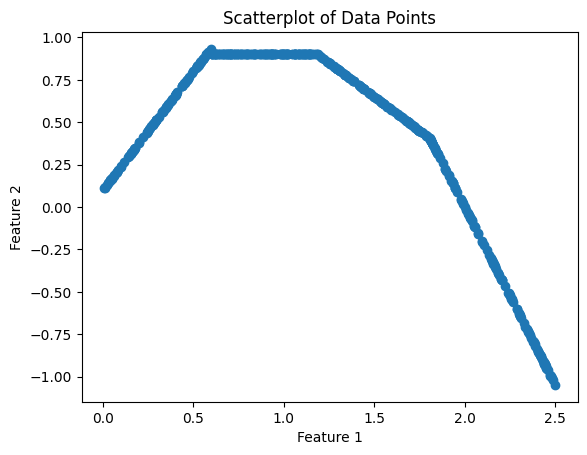

In [4]:
X, y, mask, mask_conditions = load_synthetic5()

# Scatterplot 
plt.scatter(X[:, 0], y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatterplot of Data Points')
plt.show()

In [ ]:
def train_model(X, y, mask, train_indices, GP_elite_tree=None, verbose=0):
    X_train = X[train_indices]
    y_train = y[train_indices]
    mask_train = [m[train_indices] for m in mask]

    params = GPParameters(pop_size=100, n_iter=100, max_depth=7, init_depth=3,
                            selector='dalex', p_xo=0.8, down_sampling=1, elite_tree=GP_elite_tree)
    
    ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, dataset_name='test',
                                    gp_version='gp', params_gp=params, selector='dalex', 
                                    full_return=True, seed=seed, verbose=verbose, pop_size=100, n_iter=100, p_mut=0.7, 
                                    prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                    test_elite=False, timeout=200)
    
    
    return ensemble_tree, population, spec_pop, mask_train  

def evaluate_specialist_split(ensemble_tree, last_elite, X, y, mask, train_indices, validation_indices):
    """
    Prints improvement, evaluates specialist split, and computes RMSE.
    """
    # Get the training data
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[validation_indices], y[validation_indices]
    mask_train = [m[train_indices] for m in mask]

    # Improvement
    initial_fitness = rmse(y_train, last_elite.predict(X_train)) 
    initial_val_fitness = rmse(y_val, last_elite.predict(X_val))
    final_fitness = ensemble_tree.fitness
    final_val_fitness = rmse(y_val, ensemble_tree.predict(X_val))
    improvement = 100 * (final_fitness - initial_fitness) / initial_fitness
    improvement_val = 100 * (final_val_fitness - initial_val_fitness) / initial_val_fitness
    print(f'(Train) Improvement from {round(initial_fitness,3)} to {round(final_fitness,3)} ({round(improvement,2)}%)')
    print(f'(Val) improvement from {round(initial_val_fitness,3)} to {round(final_val_fitness,3)} ({round(improvement_val,2)}%)')

    # Specialist masks and distances
    masks_specialist = get_specialist_masks(ensemble_tree.collection, X_train)
    masks_specialist_val = get_specialist_masks(ensemble_tree.collection, X_val)
    split_distance, best_combo = compute_split_distance(mask_train, masks_specialist)
    # print('Split quality:', round(split_distance,3))

    # Class balance
    elements_class = [np.sum(mask) for mask in list(masks_specialist.values())]
    total = np.sum(elements_class)
    print(f'Balance: {elements_class[0]} ({round(elements_class[0]/total, 2)}) vs {elements_class[1]} ({round(elements_class[1]/total, 2)})')

    # RMSE
    print(calculate_specialist_rmse(ensemble_tree, X_train, y_train))

    return {
        "improvement": improvement,
        "split_distance": split_distance,
        "best_combo": best_combo,
        "class_balance": elements_class,
        "masks_specialist": masks_specialist,
        "masks_specialist_val": masks_specialist_val,
    }

def split(population, results, indices, val_indices):
    """
    Splits the population into two groups based on the results of the evaluation.
    """
    masks_split = list(results['masks_specialist'].values())
    specialists_split = list(results['masks_specialist'].keys())
    masks_split_val = list(results['masks_specialist_val'].values())
    specialists_split_val = list(results['masks_specialist_val'].keys())

    indices_split_1 = indices[masks_split[0]]
    indices_split_2 = indices[masks_split[1]]
    indices_split_val_1 = val_indices[masks_split_val[0]]
    indices_split_val_2 = val_indices[masks_split_val[1]]
    
    tree_split_1 = population[0].SPECIALISTS[specialists_split[0]]
    tree_split_2 = population[0].SPECIALISTS[specialists_split[1]]
    tree_split_val_1 = population[0].SPECIALISTS[specialists_split_val[0]]
    tree_split_val_2 = population[0].SPECIALISTS[specialists_split_val[1]]

    return indices_split_1, indices_split_2, tree_split_1, tree_split_2, indices_split_val_1, indices_split_val_2, tree_split_val_1, tree_split_val_2

In [6]:
def train_model(X, y, mask, train_indices, GP_elite_tree=None, verbose=0):
    X_train = X[train_indices]
    y_train = y[train_indices]
    mask_train = [m[train_indices] for m in mask]

    params = GPParameters(pop_size=100, n_iter=100, max_depth=4, init_depth=3,
                            selector='dalex', p_xo=0.85, down_sampling=1, elite_tree=GP_elite_tree)
    
    ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, dataset_name='test',
                                    gp_version='gp', params_gp=params, selector='dalex', 
                                    full_return=True, seed=seed, verbose=verbose, pop_size=100, n_iter=100, p_mut=0.5, 
                                    prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=5, down_sampling=1,
                                    test_elite=False, timeout=200)
    
    
    return ensemble_tree, population, spec_pop, mask_train  

In [ ]:
[submask.shape[0] for submask in mask_train_idx]

In [ ]:
seed = 3

indices_1, indices_val_1 = train_test_split(X, y, p_test=0.2, indices_only=True, seed=seed)
mask_indices = [np.where(submask == True) for submask in mask]   
mask_train_idx = [np.intersect1d(mask_indices[i], indices_1) for i in range(len(mask_indices))]
mask_val_idx = [np.intersect1d(mask_indices[i], indices_val_1) for i in range(len(mask_indices))]

print('SPLIT 1')
ensemble_1, population_1, spec_pop_1, mask_train_1 = train_model(X, y, mask, indices_1)
results_1 = evaluate_specialist_split(ensemble_1, spec_pop_1[0], X, y, mask, indices_1, indices_val_1)
indices_11, indices_12, tree_11, tree_12, ival_11, ival_12, tval_11, tval_12 = split(population_1, results_1, indices_1, indices_val_1)

print('-----------------------------------------')
print('11:', [np.intersect1d(submask, indices_11).shape[0] for submask in mask_train_idx])
print('12:', [np.intersect1d(submask, indices_12).shape[0] for submask in mask_train_idx])

In [ ]:
ensemble_1.total_nodes

#### SECOND LEVEL

In [ ]:
seed = 10

print('SPLIT 1-1')

ensemble_11, population_11, spec_pop_11, mask_train_11 = train_model(X, y, mask, indices_11)
results_11 = evaluate_specialist_split(ensemble_11, tree_11, X, y, mask, indices_11, ival_11)
indices_111, indices_112, tree_111, tree_112, ival_111, ival_112, tval_111, tval_112 = split(population_11, results_11, indices_11, ival_11)

print('-----------------------------------------')
print('111:', [np.intersect1d(submask, indices_111).shape[0] for submask in mask_train_idx])
print('112:', [np.intersect1d(submask, indices_112).shape[0] for submask in mask_train_idx])

In [ ]:
plt.scatter(X[indices_111][:,0], tree_111.predict(X[indices_111]))
plt.scatter(X[:,0], y, color='red', alpha=0.5)

In [ ]:
seed = 10

print('SPLIT 1-1-1')

ensemble_111, population_111, spec_pop_111, mask_train_111 = train_model(X, y, mask, indices_111)
results_111 = evaluate_specialist_split(ensemble_111, tree_111, X, y, mask, indices_111, ival_111)
indices_1111, indices_1112, tree_1111, tree_1112, ival_1111, ival_1112, tval_1111, tval_1112 = split(population_111, results_111, indices_111, ival_111)
print('-----------------------------------------')
print('1111:', [np.intersect1d(submask, indices_1111).shape[0] for submask in mask_train_idx])
print('1112:', [np.intersect1d(submask, indices_1112).shape[0] for submask in mask_train_idx])


In [ ]:
plt.scatter(X[indices_112][:,0], tree_112.predict(X[indices_112]))
plt.scatter(X[:,0], y, color='red', alpha=0.5)

In [ ]:
seed = 12

print('SPLIT 1-2')

ensemble_12, population_12, spec_pop_12, mask_train_12 = train_model(X, y, mask, indices_12, GP_elite_tree=tree_12)
results_12 = evaluate_specialist_split(ensemble_12, tree_12, X, y, mask, indices_12, ival_12)
indices_121, indices_122, tree_121, tree_122, ival_121, ival_122, tval_121, tval_122 = split(population_12, results_12, indices_12, ival_12)

print('-----------------------------------------')
print('121:', [np.intersect1d(submask, indices_121).shape[0] for submask in mask_train_idx])
print('122:', [np.intersect1d(submask, indices_122).shape[0] for submask in mask_train_idx])

In [ ]:
plt.scatter(X[indices_12][:,0], ensemble_12.predict(X[indices_12]))
plt.scatter(X[:,0], y, color='red', alpha=0.5)

In [ ]:
print('RESPLIT 1-1 (2)')

indices_11_2 = np.concatenate((indices_11, indices_121))
ival_11_2 = np.concatenate((ival_11, ival_121))

ensemble_11_2, population_11_2, spec_pop_11_2, mask_train_11_2 = train_model(X, y, mask, indices_11_2, GP_elite_tree=tree_11)
results_11_2 = evaluate_specialist_split(ensemble_11_2, tree_11, X, y, mask, indices_11_2, ival_11_2)
indices_111_2, indices_112_2, tree_111_2, tree_112_2, ival_111_2, ival_112_2, tval_111_2, tval_112_2 = split(population_11_2, results_11_2, indices_11_2, ival_11_2)

print('-----------------------------------------')
print('111:', [np.intersect1d(submask, indices_111).shape[0] for submask in mask_train_idx])
print('112:', [np.intersect1d(submask, indices_112).shape[0] for submask in mask_train_idx])
print('111_2:', [np.intersect1d(submask, indices_111_2).shape[0] for submask in mask_train_idx])
print('112_2:', [np.intersect1d(submask, indices_112_2).shape[0] for submask in mask_train_idx])

#### THIRD LEVEL

In [ ]:
print('SPLIT 1-1-1')

ensemble_111_2, population_111_2, spec_pop_111_2, mask_train_111_2 = train_model(X, y, mask, indices_111_2, GP_elite_tree=tree_111_2)
results_111_2 = evaluate_specialist_split(ensemble_111_2, tree_111_2, X, y, mask, indices_111_2, ival_111_2)
indices_1111_2, indices_1112_2, tree_1111_2, tree_1112_2, ival_1111_2, ival_1112_2, tval_1111_2, tval_1112_2 = split(population_111_2, results_111_2, indices_111_2, ival_111_2)

print('-----------------------------------------')
print('1111_2:', [np.intersect1d(submask, indices_1111_2).shape[0] for submask in mask_train_idx])
print('1112_2:', [np.intersect1d(submask, indices_1112_2).shape[0] for submask in mask_train_idx])

In [ ]:
print('SPLIT 1-1-2')

ensemble_112_2, population_112_2, spec_pop_112_2, mask_train_112_3 = train_model(X, y, mask, indices_112_2, GP_elite_tree=tree_112)
results_112_2 = evaluate_specialist_split(ensemble_112_2, tree_112_2, X, y, mask, indices_112_2, ival_112_2)
indices_1121_2, indices_1122_2, tree_1121_2, tree_1122_2, ival_1121_2, ival_1122_2, tval_1121_2, tval_1122_2 = split(population_112_2, results_112_2, indices_112_2, ival_112_2)

print('-----------------------------------------')
print('1121_2:', [np.intersect1d(submask, indices_1121_2).shape[0] for submask in mask_train_idx])
print('1122_2:', [np.intersect1d(submask, indices_1122_2).shape[0] for submask in mask_train_idx])

continue resplit !!

In [ ]:
print('RESPLIT 1-1-2 (2)')

indices_112_3 = np.concatenate((indices_112_2, indices_1122_2))
ival_112_3 = np.concatenate((ival_112_2, ival_1122_2))

ensemble_112_2, population_112_2, spec_pop_112_2, mask_train_112_3 = train_model(X, y, mask, indices_112_2, GP_elite_tree=tree_112)
results_112_2 = evaluate_specialist_split(ensemble_112_2, tree_112_2, X, y, mask, indices_112_3, ival_112_3)
indices_1121_2, indices_1122_2, tree_1121_2, tree_1122_2, ival_1121_2, ival_1122_2, tval_1121_2, tval_1122_2 = split(population_112_2, results_112_2, indices_112_3, ival_112_3)

print('-----------------------------------------')
print('1121_2:', [np.intersect1d(submask, indices_1121_2).shape[0] for submask in mask_train_idx])
print('1122_2:', [np.intersect1d(submask, indices_1122_2).shape[0] for submask in mask_train_idx])

#### FOURTH LEVEL

In [ ]:
print('SPLIT 1-1-1-1')

ensemble_1111_2, population_1111_2, spec_pop_1111_2, mask_train_1111_2 = train_model(X, y, mask, indices_1111_2, GP_elite_tree=tree_1111_2)
results_1111_2 = evaluate_specialist_split(ensemble_1111_2, tree_1111_2, X, y, mask, indices_1111_2, ival_1111_2)
indices_11111_2, indices_11112_2, tree_11111_2, tree_11112_2, ival_11111_2, ival_11112_2, tval_11111_2, tval_11112_2 = split(population_1111_2, results_1111_2, indices_1111_2, ival_1111_2)

print('-----------------------------------------')
print('11111_2:', [np.intersect1d(submask, indices_11111_2).shape[0] for submask in mask_train_idx])
print('11112_2:', [np.intersect1d(submask, indices_11112_2).shape[0] for submask in mask_train_idx])

In [ ]:
print('SPLIT 1-1-1-2')

ensemble_1112_2, population_1112_2, spec_pop_1112_2, mask_train_1112_2 = train_model(X, y, mask, indices_1112_2, GP_elite_tree=tree_1112_2)
results_1112_2 = evaluate_specialist_split(ensemble_1112_2, tree_1112_2, X, y, mask, indices_1112_2, ival_112_2)
indices_11121_2, indices_11122_2, tree_11121_2, tree_11122_2, ival_11121_2, ival_11122_2, tval_11121_2, tval_11122_2 = split(population_1112_2, results_1112_2, indices_1112_2, ival_112_2)

print('-----------------------------------------')
print('11121_2:', [np.intersect1d(submask, indices_11121_2).shape[0] for submask in mask_train_idx])
print('11122_2:', [np.intersect1d(submask, indices_11122_2).shape[0] for submask in mask_train_idx])

In [ ]:
print('RESPLIT 1-1-1-2 (2)')

indices_1112_3 = np.concatenate((indices_11112_2, indices_1112_2))

ensemble_1112_2, population_1112_2, spec_pop_1112_2, mask_train_1112_2 = train_model(X, y, mask, indices_1112_3, GP_elite_tree=tree_1112_2)
results_1112_2 = evaluate_specialist_split(ensemble_1112_2, tree_1112_2, X, y, mask, indices_1112_3, ival_1112_2)
indices_11121_2, indices_11122_2, tree_11121_2, tree_11122_2, ival_11121_2, ival_11122_2, tval_11121_2, tval_11122_2 = split(population_1112_2, results_1112_2, indices_1112_3, ival_1112_2)

print('-----------------------------------------')
print('11121_2:', [np.intersect1d(submask, indices_11121_2).shape[0] for submask in mask_train_idx])
print('11122_2:', [np.intersect1d(submask, indices_11122_2).shape[0] for submask in mask_train_idx])

____________________________________________

In [ ]:
mt = [m[indices_11] for m in mask]
print(f'Inside: {np.sum(mt[1] + mt[2] + mt[3])} ({round(np.sum(mt[1] + mt[2] + mt[3])/np.sum(mt[0] + mt[1] + mt[2] + mt[3]),2)})')
print('Outside:', np.sum(mt[0]))

In [ ]:
# Lets check the improvement of the specialist
print(f'Improvement from {round(spec_pop_11[0].fitness,3)} to {round(ensemble_tree_11.fitness,3)} ({round(100*(ensemble_tree_11.fitness-spec_pop_11[0].fitness)/spec_pop_11[0].fitness,2)}%)')
masks_specialist_11 = get_specialist_masks(ensemble_tree_11.collection, X_train_11)
elements_class_11 = [np.sum(mask) for mask in list(masks_specialist_11.values())]
print(f'Balance: {elements_class_11[0]} ({round(elements_class_11[0]/np.sum(elements_class),2)}) vs {elements_class_11[1]} ({round(elements_class_11[1]/np.sum(elements_class),2)})')

calculate_specialist_rmse(ensemble_tree_11, X_train_11, y_train_11)

In [ ]:
Tree.SPECIALISTS['split1_1_1'] = ensemble_tree_11.SPECIALISTS[ensemble_tree_11.collection[1]]   
Tree.SPECIALISTS['split1_1_2'] = ensemble_tree_11.SPECIALISTS[ensemble_tree_11.collection[2]]
structure_new_11 = (ensemble_tree_11.collection[0], 'split1_1_1', 'split1_1_2')
ensemble_tree_new = swap_sub_tree(ensemble_tree.collection, structure_new_11, list([1]))
ensemble_tree_new = Tree(ensemble_tree_new)
new_fitness = rmse(y_train, ensemble_tree_new.predict(X_train)) 

# masks_specialist_new = get_specialist_masks(ensemble_tree_new.collection, X_train)
# split_distance_new, best_combo_new = compute_split_distance_general(mask_train, masks_specialist_new, lambda_penalty=1)
# print('Composite distance:', compute_composite_mask_distance(masks_specialist_new.values(), mask_train, lambda_penalty=1))
# print('Split quality:', split_distance_new)
# print(f'Improvement from {round(spec_pop[0].fitness,3)} to {round(new_fitness, 2)} ({round(100*(new_fitness-spec_pop[0].fitness)/spec_pop[0].fitness,2)}%)')

#### Split 22 isn't performed because only 16% goes to it. Minimum would be 20%

In [ ]:
indices_12 = train_indices[list(masks_specialist.values())[1]]
X_train_12 = X[indices_12]
y_train_12 = y[indices_12]
tree_12 = population[0].SPECIALISTS[list(masks_specialist.keys())[1]]
params = GPParameters(pop_size=100, n_iter=100, max_depth=4, init_depth=3,
                      selector='dalex', p_xo=0.8, down_sampling=1, # elite_tree=tree_12
                      )

ensemble_tree_12, population_12, spec_pop_12 = multi_slim(X_train=X_train_12, y_train=y_train_12, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='dalex', 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=100, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                test_elite=False, timeout=200)

In [ ]:
# Improvement of the specialist
print(f'Improvement from {round(spec_pop_12[0].fitness,3)} to {round(ensemble_tree_12.fitness,3)} ({round(100*(ensemble_tree_12.fitness-spec_pop_12[0].fitness)/spec_pop_12[0].fitness,2)}%)')
masks_specialist_12 = get_specialist_masks(ensemble_tree_12.collection, X_train_12)
elements_class_12 = [np.sum(mask) for mask in list(masks_specialist_12.values())]
print(f'Balance: {elements_class_12[0]} ({round(elements_class_12[0]/np.sum(elements_class),2)}) vs {elements_class_12[1]} ({round(elements_class_12[1]/np.sum(elements_class),2)})')

calculate_specialist_rmse(ensemble_tree_12, X_train_12, y_train_12)

In [ ]:
indices_122 = indices_12[list(masks_specialist_12.values())[1]]
mt122 = [m[indices_122] for m in mask]
inside = np.sum(mt122[0])
print(f'Inside: {inside} ({round(inside/np.sum(mt122[0] + mt122[1] + mt122[2] + mt122[3]),2)}), representing: {round(inside/np.sum(mask_train[0]), 2)}')
print('Outside:', np.sum(mask_train[0]) - inside)

In [ ]:
indices_121 = indices_12[list(masks_specialist_12.values())[0]]
mt121 = [m[indices_121] for m in mask]
inside = np.sum(mt121[0])
print(f'Inside: {inside} ({round(inside/np.sum(mt121[0] + mt121[1] + mt121[2] + mt121[3]),2)})')
print('Outside:', np.sum(mt121[1] + mt121[2] + mt121[3]))

In [ ]:
indices222 = indices_12[list(masks_specialist_12.values())[1]]
X_train222 = X[indices222]
y_train222 = y[indices222]
tree222 = population[0].SPECIALISTS[list(masks_specialist_12.keys())[1]]
params = GPParameters(pop_size=100, n_iter=100, max_depth=4, init_depth=3,
                      selector='dalex', p_xo=0.8, down_sampling=1, elite_tree=tree222)

ensemble_tree_222, population_222, spec_pop_222 = multi_slim(X_train=X_train222, y_train=y_train222, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='dalex', 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=100, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                test_elite=False, timeout=200)

In this case, the 2 entries should be redistributed, but how to reinvent the conditions to do so? 

#### New splits: 111, 112

In [ ]:
indices_111 = indices_11[list(masks_specialist_11.values())[0]]

X_train_111 = X[indices_111]
y_train_111 = y[indices_111]
tree_111 = population_11[0].SPECIALISTS[list(masks_specialist_11.keys())[0]]

params = GPParameters(pop_size=100, n_iter=100, max_depth=7, init_depth=3,
                        selector='dalex', p_xo=0.8, down_sampling=1, elite_tree=tree_111)

ensemble_tree_111, population_111, spec_pop_111 = multi_slim(X_train=X_train_111, y_train=y_train_111, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='dalex', 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=100, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                test_elite=False, timeout=200)

In [ ]:
mt111 = [m[indices_111] for m in mask]
print(f'Inside: {np.sum(mt111[1] + mt111[3])} ({round(np.sum(mt111[1] + mt111[3])/np.sum(mt111[0] + mt111[1] + mt111[2] + mt111[3]),2)})')
print('Outside:', np.sum(mt111[0] + mt111[2]))

In [ ]:
# Improvement of the specialist
print(f'Improvement from {round(spec_pop_111[0].fitness,3)} to {round(ensemble_tree_111.fitness,3)} ({round(100*(ensemble_tree_111.fitness-spec_pop_111[0].fitness)/spec_pop_111[0].fitness,2)}%)')
masks_specialist_111 = get_specialist_masks(ensemble_tree_111.collection, X_train_111)
elements_class_111 = [np.sum(mask) for mask in list(masks_specialist_111.values())]

print(f'Balance: {elements_class_111[0]} ({round(elements_class_111[0]/np.sum(elements_class),2)}) vs {elements_class_111[1]} ({round(elements_class_111[1]/np.sum(elements_class),2)})')
calculate_specialist_rmse(ensemble_tree_111, X_train_111, y_train_111)

In [ ]:
indices_1111 = indices_111[list(masks_specialist_111.values())[0]]
mt_1111 = [m[indices_1111] for m in mask]
inside = np.sum(mt_1111[1] + mt_1111[2] + mt_1111[3])
print(f'Inside: {inside} ({round(inside/(np.sum(mt_1111[0] + mt_1111[1] + mt_1111[2] + mt_1111[3])),2)}), representing: {round(inside/np.sum(mask_train[0] + mask_train[1] + mask_train[2] + mask_train[3]), 2)}')
print('Outside:', np.sum(mt_1111[0]))

In [ ]:
indices_1112 = indices_111[list(masks_specialist_111.values())[1]]
mt_1112 = [m[indices_1112] for m in mask]
print(f'Inside: {np.sum(mt_1112[1] + mt_1112[2] + mt_1112[3])} ({round(np.sum(mt_1112[1] + mt_1112[2] + mt_1112[3])/np.sum(mt_1112[0] + mt_1112[1] + mt_1112[2] + mt_1112[3]),2)})')
print('Outside:', np.sum(mt_1112[0]))

In [ ]:
X_train_2111 = X[indices_1111]
y_train_2111 = y[indices_1111]
tree_2111 = population_111[0].SPECIALISTS[list(masks_specialist_111.keys())[0]]

params = GPParameters(pop_size=100, n_iter=100, max_depth=7, init_depth=3,
                        selector='dalex', p_xo=0.8, down_sampling=1, elite_tree=tree_2111)

ensemble_tree_2111, population_2111, spec_pop_2111 = multi_slim(X_train=X_train_2111, y_train=y_train_2111, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='dalex', 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=100, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                test_elite=False, timeout=200)

Split 212

In [ ]:
indices_112 = indices_11[list(masks_specialist_11.values())[1]]

X_train_112 = X[indices_112]
y_train_112 = y[indices_112]
tree_112 = population_11[0].SPECIALISTS[list(masks_specialist_11.keys())[0]]

params = GPParameters(pop_size=100, n_iter=100, max_depth=7, init_depth=3,
                        selector='dalex', p_xo=0.8, down_sampling=1, elite_tree=tree_112)

ensemble_tree_112, population_112, spec_pop_112 = multi_slim(X_train=X_train_112, y_train=y_train_112, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='dalex', 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=100, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                test_elite=False, timeout=200)

In [ ]:
# Improvement of the specialist
print(f'Improvement from {round(spec_pop_112[0].fitness,3)} to {round(ensemble_tree_112.fitness,3)} ({round(100*(ensemble_tree_112.fitness-spec_pop_112[0].fitness)/spec_pop_112[0].fitness,2)}%)')
masks_specialist_112 = get_specialist_masks(ensemble_tree_112.collection, X_train_112)
elements_class_112 = [np.sum(mask) for mask in list(masks_specialist_112.values())]
print(f'Balance: {elements_class_112[0]} ({round(elements_class_112[0]/np.sum(elements_class),2)}) vs {elements_class_112[1]} ({round(elements_class_112[1]/np.sum(elements_class),2)})')
calculate_specialist_rmse(ensemble_tree_112, X_train_112, y_train_112)

In [ ]:
mt_112 = [m[indices_112] for m in mask]
print(f'Inside: {np.sum(mt_112[2])} ({round(np.sum(mt_112[2])/np.sum(mt_112[0] + mt_112[1] + mt_112[2] + mt_112[3]),2)})')
print('Outside:', np.sum(mt_112[0]))

### Integrated algorithm
______________________________________________________

In [4]:
def train_ensemble(X, y, train_indices, GP_elite_tree=None, verbose=0, seed=0,
                   iter_GP=100, iter_MS=100, md_GP=7, ps_GP=100, ps_MS=100, pp_GP=20
                    ):
    X_train = X[train_indices]
    y_train = y[train_indices]

    params = GPParameters(pop_size=ps_GP, n_iter=iter_GP, max_depth=md_GP, init_depth=3,
                            selector='dalex', p_xo=0.8, down_sampling=1, elite_tree=GP_elite_tree, 
                            particularity_pressure=pp_GP)
    
    ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, dataset_name='test',
                                    gp_version='gp', params_gp=params, selector='dalex', 
                                    full_return=True, seed=seed, verbose=verbose, pop_size=ps_MS, n_iter=iter_MS, p_mut=0.7, 
                                    prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                    test_elite=False, timeout=200)
    
    
    return ensemble_tree, population, spec_pop  

def train_GP(X, y, train_indices, GP_elite_tree=None, verbose=0, seed=0, 
             iter_GP=100, md_GP=7, ps_GP=100, pp_GP=20):
    
    X_train = X[train_indices]
    y_train = y[train_indices]

    params = GPParameters(pop_size=ps_GP, n_iter=iter_GP, max_depth=md_GP, init_depth=3,
                            selector='dalex', p_xo=0.8, down_sampling=1, elite_tree=GP_elite_tree, 
                            particularity_pressure=pp_GP)
    
    elite = gp(X_train=X_train, y_train=y_train, dataset_name='test',
                            **params.__dict__, full_return=False, seed=seed, verbose=verbose,
                            test_elite=False)
    
    return elite

def evaluate_specialist_split(ensemble_tree, last_elite, X, y, mask, train_indices, validation_indices=None, verbose=True):
    """
    Prints improvement, evaluates specialist split, and computes RMSE.
    """
    # Get the training data
    X_train, y_train = X[train_indices], y[train_indices]
    mask_train = [m[train_indices] for m in mask]

    # Improvement
    initial_fitness = rmse(y_train, last_elite.predict(X_train)) 
    final_fitness = ensemble_tree.fitness
    improvement = 100 * (final_fitness - initial_fitness) / initial_fitness

    # Specialist masks and distances
    masks_specialist = get_specialist_masks(ensemble_tree.collection, X_train)
    split_distance, best_combo = compute_split_distance(mask_train, masks_specialist)

    # Class balance
    elements_class = [np.sum(mask) for mask in list(masks_specialist.values())]
    total = np.sum(elements_class)

    if verbose:
        print(f'(Train) Improvement from {round(initial_fitness,3)} to {round(final_fitness,3)} ({round(improvement,2)}%)')

    if validation_indices is not None:
        X_val, y_val = X[validation_indices], y[validation_indices] 
        initial_val_fitness = rmse(y_val, last_elite.predict(X_val))
        final_val_fitness = rmse(y_val, ensemble_tree.predict(X_val))
        improvement_val = 100 * (final_val_fitness - initial_val_fitness) / initial_val_fitness
        masks_specialist_val = get_specialist_masks(ensemble_tree.collection, X_val)

        if verbose: 
            print(f'(Val) improvement from {round(initial_val_fitness,3)} to {round(final_val_fitness,3)} ({round(improvement_val,2)}%)')

    if verbose:
        print(f'Balance: {elements_class[0]} ({round(elements_class[0]/total, 2)}) vs {elements_class[1]} ({round(elements_class[1]/total, 2)})')
        print(calculate_specialist_rmse(ensemble_tree, X_train, y_train))

    return {
        "improvement": improvement,
        "split_distance": split_distance,
        "best_combo": best_combo,
        "class_balance": elements_class,
        "masks_specialist": masks_specialist,
        "masks_specialist_val": masks_specialist_val if validation_indices is not None else None,
    }

def split(population, results, indices, val_indices):
    """
    Splits the population into two groups based on the results of the evaluation.
    """
    masks_split = list(results['masks_specialist'].values())
    specialists_split = list(results['masks_specialist'].keys())
    masks_split_val = list(results['masks_specialist_val'].values())
    specialists_split_val = list(results['masks_specialist_val'].keys())

    indices_split_1 = indices[masks_split[0]]
    indices_split_2 = indices[masks_split[1]]
    indices_split_val_1 = val_indices[masks_split_val[0]]
    indices_split_val_2 = val_indices[masks_split_val[1]]
    
    tree_split_1 = population[0].SPECIALISTS[specialists_split[0]]
    tree_split_2 = population[0].SPECIALISTS[specialists_split[1]]
    tree_split_val_1 = population[0].SPECIALISTS[specialists_split_val[0]]
    tree_split_val_2 = population[0].SPECIALISTS[specialists_split_val[1]]

    return indices_split_1, indices_split_2, tree_split_1, tree_split_2, indices_split_val_1, indices_split_val_2, tree_split_val_1, tree_split_val_2

def children_ids(node): 
    child_ids = []
    def recursion(node, current_path=()):
        if node.children: 
            # There is children still 
            recursion(node.children[0] , current_path + (1,))
            recursion(node.children[1], current_path + (2,))
        else: 
            child_ids.append(current_path)
    recursion(node)
    return child_ids

def calculate_cluster_idx(node): 
    cluster_indices = []
    def recursion(node): 
        if node.children: 
            recursion(node.children[0]) 
            recursion(node.children[1])
        else: 
            cluster_indices.append(node.indices)
    recursion(node)
    return cluster_indices

def calculate_silhouette(node): 
    labels = np.zeros(len(node.X), dtype=int)
    cluster_indices = calculate_cluster_idx(node)
    
    for i, cluster in enumerate(cluster_indices):
        labels[cluster] = i
    
    # compute silhouette score
    return silhouette_score(node.X, labels)

def grow(node, max_depth=4, current_depth=0, verbose=1):
    """
    Recursively fit & evaluate by always indexing into node.children
    rather than iterating a changing list.
    """
    child_ids = children_ids(node)
    child_ids_valid = [id for id in child_ids if len(id) == current_depth+1]

    if len(child_ids_valid) == 0:
        return

    for id in child_ids_valid:
        node[id].fit_and_evaluate(verbose=verbose)
        print('Current_silhouette:', round(calculate_silhouette(node),2))
    
    grow(node, max_depth, current_depth+1) if current_depth < max_depth else None


In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
import numpy as np

def sample_hyperparams():
    return {
        'iter_GP': np.random.randint(1, 7) * 50,
        'iter_MS': np.random.randint(1, 7) * 50,
        'md_GP': np.random.randint(3, 8),        
        'ps_GP': np.random.randint(1, 5) * 50,  
        'ps_MS': np.random.randint(1, 5) * 50,
        'seed': np.random.randint(0, 100000)
    }

class PiecewiseNode:
    def __init__(self, X, y, indices, mask=None, current_index=(),
                 parent_tree=None, config=None, params=None, depth=0, seed=0):
        self.X, self.y, self.mask = X, y, mask
        self.indices = indices
        self.seed = seed
        self.parent_tree = parent_tree
        self.current_index = current_index
        self.depth = depth
        self.children = []
        
        # default config; you can override by passing config dict
        self.config = {
            'min_sse_reduction': 1e-4,
            'min_leaf_share': 0.05,
            'use_aic': False,
            'use_bic': True,
            'cv_folds': 5,
            'max_resplits': 3,       
            'resplit_threshold': 0.4,   
            'silhouette_trials': 5,
        }

        self.params = { 
            'iter_GP' : 100, 
            'iter_MS': 100,
            'md_GP': 7,       
            'ps_GP': 100,
            'ps_MS': 100,
            'pp_GP' : 20,
        }

        if config: 
            self.config.update(config)

        if params: 
            self.params.update(params)
        
        self.config['min_leaf_size'] = int(self.config['min_leaf_share'] * len(self.X))
        self.config['resplit_size'] = int(self.config['resplit_threshold'] * len(self.X))
        
        # placeholders for fit results:
        self.ensemble = None
        self.pop = None
        self.spec_pop = None
        self.metrics = {}
        self.used_resplits = 0 
        self.best_tree = (None, np.inf)

    def fit_and_evaluate(self, verbose=0):
        print('-'*20, self.current_index, '-'*20) if verbose > 0 else None  

        # 1) Train
        X_tr = self.X[self.indices]
        y_tr = self.y[self.indices]

        # # First split
        # if self.children == []:
        #      self.first_fit(verbose=verbose)

        # else:
        # reuse your train_model call, but return only what we need
        self.ensemble, self.pop, self.spec_pop = train_ensemble(
            self.X, self.y, self.indices,
            GP_elite_tree=[self.parent_tree], verbose=(True if verbose > 2 else False),  # SHOULD I USE GP_ELITE_TREE?
            seed=self.seed + self.used_resplits*100,
            iter_GP=self.params['iter_GP']+25*self.used_resplits, iter_MS=self.params['iter_MS']+25*self.used_resplits,
            md_GP=self.params['md_GP'], ps_GP=self.params['ps_GP'],
            ps_MS=self.params['ps_MS'], pp_GP=self.params['pp_GP'],
        )

        if self.spec_pop[0].fitness < self.best_tree[1]:
            self.best_tree = (self.spec_pop[0], self.spec_pop[0].fitness)

        if self.parent_tree is None: 
            self.parent_tree = self.spec_pop[0]

        if type(self.ensemble.collection) == str: 
            # It didnt split, so we stop here 
            print("✘ stopping: no split") if verbose > 0 else None
            self.ensemble = None
            return False

        # 2) Evaluate parent SSE
        parent_pred = self.parent_tree.predict(X_tr)
        sse_parent = np.sum((y_tr - parent_pred)**2)
        rmse_parent = rmse(y_tr, parent_pred)

        # 3) Evaluate children via your specialist split
        masks_tree = get_specialist_masks(self.ensemble.collection, self.X[self.indices])    
        masks = list(masks_tree.values())

        # child indices and trees 
        idx1, t1 = self.indices[masks[0]], self.pop[0].SPECIALISTS[list(masks_tree.keys())[0]]
        idx2, t2 = self.indices[masks[1]], self.pop[0].SPECIALISTS[list(masks_tree.keys())[1]]
        self.metrics['n1'], self.metrics['n2'] = len(idx1), len(idx2)

        # sse children obtained automatically with the ensemble model
        sse_children = np.sum((y_tr-self.ensemble.predict(X_tr))**2)
        rmse_children = rmse(y_tr, self.ensemble.predict(X_tr))

        # 
        sil_score = 0

        # 4) SSE reduction
        delta_sse, delta_rmse = sse_parent - sse_children, rmse_parent - rmse_children

        if verbose > 0:
            print(f"SSE_parent   = {sse_parent:.4f}, SSE_children = {sse_children:.4f} -> {-delta_sse/sse_parent:.2%}")
            print(f"RMSE_parent  = {rmse_parent:.4f}, RMSE_children = {rmse_children:.4f} -> {-delta_rmse/rmse_parent:.2%}") if verbose > 1 else None
            print(f"Leaf sizes   = {self.metrics['n1']}, {self.metrics['n2']}")
            print(f"Silhouette score of the split: {sil_score:.4f}") if verbose > 1 else None

            if self.mask:
                intersect_1 = [np.intersect1d(submask, idx1).shape[0] for submask in self.mask]
                intersect_2 = [np.intersect1d(submask, idx2).shape[0] for submask in self.mask]
                print(f"Correspondance {self.current_index+(1,)}: {intersect_1}")
                print(f"Correspondance {self.current_index+(2,)}: {intersect_2}")

        self.metrics['sse_parent']   = sse_parent
        self.metrics['sse_children'] = sse_children
        self.metrics['delta_sse']    = delta_sse
        self.metrics['delta_rmse']   = delta_rmse

        if delta_sse < self.config['min_sse_reduction']:
            if self.used_resplits < self.config['max_resplits'] and self.config['resplit_size'] <= len(self.indices):
                print("<-> resplitting: ΔSSE below threshold <->") if verbose > 0 else None
                self.used_resplits += 1
                return self.fit_and_evaluate(verbose=verbose)

            else:
                print("✘ stopping: ΔSSE below threshold") if verbose > 0 else None
                self.ensemble = None
                return False
        
        if self.metrics['n1'] < self.config['min_leaf_size'] or self.metrics['n2'] < self.config['min_leaf_size']:
            if self.used_resplits < self.config['max_resplits'] and self.config['resplit_size'] <= len(self.indices):
                print("<-> resplitting: one leaf too small <->") if verbose > 0 else None
                self.used_resplits += 1
                return self.fit_and_evaluate(verbose=verbose)
            
            else:
                print("✘ stopping: one leaf too small") if verbose > 0 else None
                self.ensemble = None
                return False

        # 5) AIC/BIC if requested
        n = len(y_tr)
        k_parent   = self.parent_tree.nodes_count
        k_children = self.ensemble.total_nodes
        if self.config['use_aic']:
            aic_parent   = 2*k_parent   + n*np.log(sse_parent/n)
            aic_children = 2*k_children + n*np.log(sse_children/n)
            self.metrics['aic_parent'], self.metrics['aic_children'] = aic_parent, aic_children
            print(f"AIC: {aic_parent:.4f} vs {aic_children:.4f}") if verbose > 0 else None

            if aic_children >= aic_parent:
                if self.used_resplits < self.config['max_resplits'] and self.config['resplit_size'] <= len(self.indices):
                    print("<-> resplitting: AIC did not improve <->") if verbose > 0 else None
                    self.used_resplits += 1
                    return self.fit_and_evaluate(verbose=verbose)
                else:
                    print("✘ stopping: AIC did not improve") if verbose > 0 else None
                    self.ensemble = None
                    return False

        if self.config['use_bic']:
            bic_parent   = k_parent*np.log(n)   + n*np.log(sse_parent/n)
            bic_children = k_children*np.log(n) + n*np.log(sse_children/n)
            self.metrics['bic_parent'], self.metrics['bic_children'] = bic_parent, bic_children
            print(f"BIC: {bic_parent:.4f} vs {bic_children:.4f}") if verbose > 1 else None

            if bic_children >= bic_parent:
                if self.used_resplits < self.config['max_resplits'] and self.config['resplit_size'] <= len(self.indices):
                    print("<-> resplitting: BIC did not improve <->") if verbose > 0 else None
                    self.used_resplits += 1
                    return self.fit_and_evaluate(verbose=verbose)
                else:
                    print("✘ stopping: BIC did not improve") if verbose > 0 else None
                    self.ensemble = None
                    return False

        # 6) Cross‐validation (combined pipelines)
        if self.config['cv_folds'] > 1:
            mse_parent, mse_split = self._cv_compare_pipelines(verbose=verbose)
            self.metrics['cv_parent']   = mse_parent
            self.metrics['cv_children'] = mse_split
            print(f"CV: {mse_parent:.4f} vs {mse_split:.4f} ({(mse_split-mse_parent)/mse_parent:.2%})") if verbose > 1 else None

            if mse_split >= mse_parent:
                if self.used_resplits < self.config['max_resplits'] and self.config['resplit_size'] <= len(self.indices):
                    print("<-> resplitting: CV did not improve <->") if verbose > 0 else None
                    self.used_resplits += 1
                    return self.fit_and_evaluate(verbose=verbose)
                else:
                    print("✘ stopping: CV did not improve") if verbose > 0 else None
                    self.ensemble = None
                    return False

        # 7) decide
        self.split(idx1, t1, idx2, t2, verbose)

    def first_fit(self, verbose=0): 
        tries, best_score, best_train_result = 0, -1, None
        while self.config['silhouette_trials'] > tries:
            tries += 1
            params = sample_hyperparams()
            ensemble, pop, spec_pop = train_ensemble(
                self.X, self.y, self.indices,
                GP_elite_tree=[self.parent_tree], verbose=(True if verbose > 2 else False),  # SHOULD I USE GP_ELITE_TREE?
                **params,
            )

            masks_tree = get_specialist_masks(ensemble.collection, self.X[self.indices])    
            masks = list(masks_tree.values())
    
            # labels for the sihouette score
            labels = np.zeros(len(self.indices), dtype=int)
            labels[masks[0]] = 1

            X_split = self.X[self.indices]
            sil_score = silhouette_score(X_split, labels)
            if sil_score > best_score:
                best_score = sil_score
                self.ensemble, self.pop, self.spec_pop = ensemble, pop, spec_pop
                print(f"New best silhouette score: {best_score:.4f}") if verbose > 1 else None

            print(f"Silhouette score of the split: {sil_score:.4f}") if verbose > 1 else None
            idx1, t1 = self.indices[masks[0]], pop[0].SPECIALISTS[list(masks_tree.keys())[0]]
            idx2, t2 = self.indices[masks[1]], pop[0].SPECIALISTS[list(masks_tree.keys())[1]]
            intersect_1 = [np.intersect1d(submask, idx1).shape[0] for submask in self.mask]
            intersect_2 = [np.intersect1d(submask, idx2).shape[0] for submask in self.mask]
            print(f"Correspondance {self.current_index+(1,)}: {intersect_1}")
            print(f"Correspondance {self.current_index+(2,)}: {intersect_2}")

        return best_train_result

    def split(self, idx1, t1, idx2, t2, verbose):
        if verbose > 2:
            print("✔ split accepted, creating child nodes")
        self.children = [
            PiecewiseNode(self.X, self.y, idx1, self.mask, parent_tree=t1,
                        config=self.config, depth=self.depth+1, current_index=self.current_index+(1,)),
            PiecewiseNode(self.X, self.y, idx2, self.mask, parent_tree=t2,
                        config=self.config, depth=self.depth+1, current_index=self.current_index+(2,)),
        ]

    def _cv_compare_pipelines(self, verbose):
        """
        Runs a single KFold CV loop.  On each fold:
         - retrain generalist, test → err_parent
         - retrain generalist→split→specialists, test → err_split
        Returns (mean_err_parent, mean_err_split).
        """
        verbose = True if verbose > 2 else False 
        folds = self.config['cv_folds']
        kf = KFold(n_splits=folds, shuffle=True, random_state=self.seed)
        idx_all = self.indices.copy()

        errs_parent = []
        errs_split  = []

        for fold_idx, (train_idxs, test_idxs) in enumerate(kf.split(idx_all)):
            tr = idx_all[train_idxs]
            te = idx_all[test_idxs]

            # --- Pipeline A: no split (retrain generalist) ---
            elite = train_GP(
                self.X, self.y,
                train_indices=tr,
                GP_elite_tree=None,     # always scratch
                seed=self.seed + fold_idx,
                verbose=verbose,
            )
            yhatA = elite.predict(self.X[te])
            errs_parent.append(rmse(self.y[te], yhatA))

            # --- Pipeline B: split & specialists ---
            ensemble, _, _  = train_ensemble(
                self.X, self.y, train_indices=tr,
                GP_elite_tree=None,
                seed=self.seed + fold_idx,
                verbose=verbose,
            )
            yhatB = ensemble.predict(self.X[te])
            errs_split.append(rmse(self.y[te], yhatB))
        return np.mean(errs_parent), np.mean(errs_split)
    
    def cluster_idx(self):
        cluster_indices = []

        def recursion(node): 
            # I need to retrieve the children 
            if node.children: 
                # There is children still 
                recursion(node.children[0]) 
                recursion(node.children[1])
            # Cant choose the current index, because it is being split 
            elif node.current_index != self.current_index: 
                cluster_indices.append(node.indices)

        recursion(self)
        return cluster_indices
    
    def __getitem__(self, index): 
        item = self
        for i in index: 
            item = item.children[i-1]
        return item
    
    def copy(self): 
        return PiecewiseNode(self.X, self.y, self.indices, self.mask, parent_tree=self.parent_tree,
                             config=self.config, params=self.params, depth=self.depth, seed=self.seed)
    
    def calculate_rmse(self): 

        def collect_predictions(node): 
            if node.children: 
                # There is children still 
                collect_predictions(node.children[0]) 
                collect_predictions(node.children[1])
            else: 
                # Cant choose the current index, because it is being split 
                node.metrics['rmse'] = rmse(node.y[node.indices], node.ensemble.predict(node.X[node.indices]))

Class 1 has 167 samples, and class 2 has 333 samples


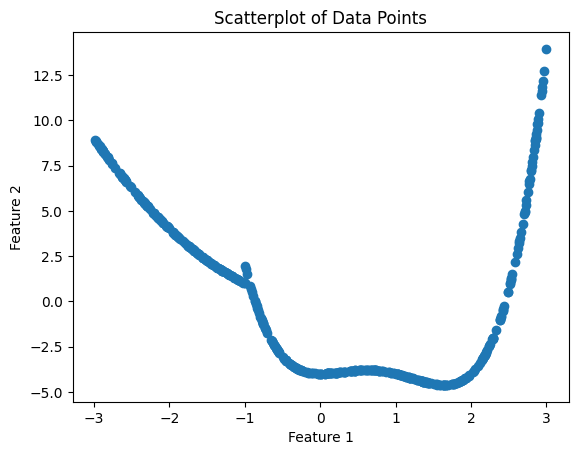

In [5]:
X, y, mask, mask_conditions = load_synthetic3()

# Scatterplot 
plt.scatter(X[:, 0], y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatterplot of Data Points')
plt.show()


In [ ]:
root_indices = np.arange(len(y))
mask_ids = [np.where(submask)[0] for submask in mask]

config = {
    'min_sse_reduction': 1e-2,
    'use_aic': True,
    'use_bic': False,
    'cv_folds': 0,
    'max_resplits': 5,
    'resplit_threshold': 0.4,
    'min_leaf_share': 0.1,
    'silhouette_trials' : 50,
}

params = { 
    'iter_GP' : 100, 
    'iter_MS': 100,
    'md_GP': 5,       
    'ps_GP': 200,
    'ps_MS': 100,
    'pp_GP' : 25,
}

verbose=1

mask_ids = [np.where(submask)[0] for submask in mask]
root = PiecewiseNode(X=X, y=y, indices=root_indices, mask=mask_ids,
                     config=config, params=params, depth=0, seed=120)

root.fit_and_evaluate(verbose=verbose)
print('Current_silhouette:', round(calculate_silhouette(root),2))

grow(root, verbose=verbose)

for id in children_ids(root): 
    indices = root[id].indices
    print(f'Correspondance {id}: {[np.intersect1d(submask, indices).shape[0] for submask in mask_ids]}')

In [8]:
def get_ensemble_tree(node):
    specialist_count, specialist_dict = 0, {}
    def traverse(node): 
        if node.children:
            condition = Condition(node.ensemble.collection[0].repr_)
            return (condition, traverse(node.children[0]), traverse(node.children[1]))
        else: 
            nonlocal specialist_count
            specialist_count += 1
            specialist_dict[f'S_{specialist_count}'] = GP_Tree(node.best_tree[0].repr_)
            return f'S_{specialist_count}'  
        
    tree = traverse(node)
    Tree.SPECIALISTS = specialist_dict 
    tree = Tree(tree)
    tree.SPECIALISTS = specialist_dict
    return tree

def try_variations_tree(ensemble, X, y): 
    def collapse(collection):
        def traverse(coll):
            if isinstance(coll, tuple):
                cond, L, R = coll
                L2 = traverse(L)
                R2 = traverse(R)
                # if both sides collapse to the same thing, eliminate the condition
                if L2 == R2:
                    return L2
                return (cond, L2, R2)
            else:
                return coll
        prev = collection
        while True:
            nxt = traverse(prev)
            if nxt == prev:
                return nxt
            prev = nxt
    
    ids = [id[0] for id in get_specialist_indices(ensemble.collection)]
    best_ensemble = (None, np.inf)
    Tree.SPECIALISTS = ensemble.SPECIALISTS.copy()

    for combination in itertools.combinations(ids, 2):
        # Substitute [0] with [1] in the tree
        ensemble_0, ensemble_1 = ensemble[combination[0]], ensemble[combination[1]]
                
        if ensemble_0 == ensemble_1:
            continue 

        new_collection_0 = swap_sub_tree(ensemble.collection, ensemble_0, combination[1])
        new_ensemble_0 = Tree(new_collection_0)
        new_ensemble_0.SPECIALISTS = ensemble.SPECIALISTS.copy()
        rmse_0 = rmse(new_ensemble_0.predict(X), y)

        # Substitute [1] with [0] in the tree
        new_collection_1 = swap_sub_tree(ensemble.collection, ensemble_1, combination[0])
        new_ensemble_1 = Tree(new_collection_1)
        new_ensemble_1.SPECIALISTS = ensemble.SPECIALISTS.copy()
        rmse_1 = rmse(new_ensemble_1.predict(X), y)

        if rmse_0 < best_ensemble[1]:
            best_ensemble = (new_ensemble_0, rmse_0)
        if rmse_1 < best_ensemble[1]:
            best_ensemble = (new_ensemble_1, rmse_1)
        
    # Simplify the tree
    ensemble_collection = collapse(best_ensemble[0].collection)
    ensemble = Tree(ensemble_collection)
    ensemble.SPECIALISTS = best_ensemble[0].SPECIALISTS.copy()

    return ensemble 

def optimize_specialist(ensemble, X, y, seed=0, extra_effort=False, verbose=False):
    # Simplify the specialists
    masks = get_specialist_masks(ensemble.collection, X)
    specialists = [ensemble.SPECIALISTS[sp_id] for sp_id in masks.keys()]
    for sp_id in masks.keys(): 
        simplified_specialist = recursive_simplification(ensemble.SPECIALISTS[sp_id], 0, X[masks[sp_id]], y[masks[sp_id]])
        opt_spec_1 = train_GP(X, y, masks[sp_id],
                                    GP_elite_tree=specialists, 
                                    verbose=verbose, seed=seed, iter_GP = (600 if extra_effort else 400), pp_GP=5, md_GP= (8 if extra_effort else 7))
        opt_spec_2 = train_GP(X, y, masks[sp_id],
                                    verbose=verbose, seed=seed, iter_GP = (800 if extra_effort else 500), pp_GP=5, md_GP= (7 if extra_effort else 4))
        # Choose the best one s
        if rmse(opt_spec_1.predict(X[masks[sp_id]]), y[masks[sp_id]]) < rmse(opt_spec_2.predict(X[masks[sp_id]]), y[masks[sp_id]]): 
            optimized_specialist = opt_spec_1
        else:
            optimized_specialist = opt_spec_2
        
        optimized_specialist = recursive_simplification(optimized_specialist, 0, X[masks[sp_id]], y[masks[sp_id]])
        ensemble.SPECIALISTS[sp_id] = optimized_specialist     

    return ensemble

def simplification_ensemble(root, X, y, verbose=0, seed=0):
    ensemble = get_ensemble_tree(root)
    initial_rmse = rmse(ensemble.predict(X), y)
    extra_effort = False

    # First try to simplify with no optimizations 
    current = ensemble
    ensembles = []
    while True:
        # If the collection is a string, we cannot try more variations 
        if type(current.collection) == str:
            break

        last_rmse = rmse(current.predict(X), y)
        current = try_variations_tree(current, X, y)        
        current_rmse = round(rmse(current.predict(X), y), 2)

        # Loop
        if current_rmse in [value[1] for value in ensembles]:
            break 

        ensembles.append((current, current_rmse, 100*(current_rmse-last_rmse)/last_rmse))

    # Max loss of 5% is allowed
    valid_ensembles = [e for e in ensembles if e[2] < 5]
    current_rmse = initial_rmse 

    # If no immediate optimizations fit the restrictions, optimize step-by-step 
    if len(valid_ensembles) != 0:
        ensemble_ = valid_ensembles[-1][0]
        ensemble_ = optimize_specialist(ensemble, X, y, seed=seed, verbose=(True if verbose > 1 else False))

        print(f"Improvement (RMSE): {round(100*(rmse(ensemble_.predict(X), y)-initial_rmse)/initial_rmse,2)}%") if verbose > 0 else None 
        print(f"Improvement (Size): {round(100*(ensemble_.total_nodes-ensemble.total_nodes)/ensemble.total_nodes,2)}%") if verbose > 0 else None
        current_rmse = rmse(ensemble_.predict(X), y)
        ensemble = ensemble_ 
    
    while True: 
        if type(ensemble.collection) == str:
            return ensemble

        seed += 1
        new_ensemble = try_variations_tree(ensemble, X, y)
        
        if type(new_ensemble.collection) == str:
            # Its a node only, so we need a little more effort to simplify it
            extra_effort = True
            
        new_ensemble = optimize_specialist(new_ensemble, X, y, seed=seed, extra_effort=extra_effort, verbose=(True if verbose > 1 else False))
        new_rmse = rmse(new_ensemble.predict(X), y)
        
        if new_rmse < current_rmse:
            if verbose:
                print(f"Improvement (RMSE): {round(100*(new_rmse-current_rmse)/current_rmse,2)}%") if verbose else None
                print(f"Improvement (Size): {round(100*(new_ensemble.total_nodes-ensemble.total_nodes)/ensemble.total_nodes,2)}%") if verbose > 0 else None
            ensemble = new_ensemble
            current_rmse = new_rmse

        else:
            print(f'Stopping simplification, no improvement found') if verbose else None
            break
    
    # Now lets re-train the ensemble as a final step with the specialists used 
    masks = get_specialist_masks(ensemble.collection, X)
    population = Population([ensemble.SPECIALISTS[sp_id] for sp_id in masks.keys()])
    ensemble, _, _ = multi_slim(X_train=X, y_train=y, dataset_name='test',
                                gp_version='gp', selector='dalex', population=population,
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=1000, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                test_elite=False, timeout=200)
    
    print(f'Final improvement (RMSE): {round(100*(rmse(ensemble.predict(X), y)-initial_rmse)/initial_rmse,2)}%') if verbose > 0 else None
    print(f'Final improvement (Size): {round(100*(new_ensemble.total_nodes-ensemble.total_nodes)/ensemble.total_nodes,2)}%') if verbose > 0 else None

    return ensemble  

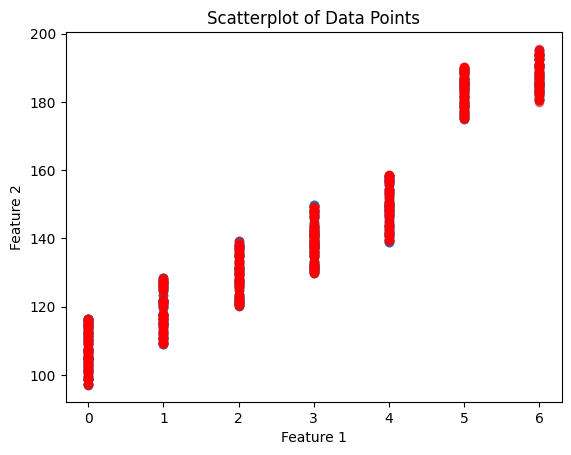

In [9]:
X, y, mask, mask_conditions = load_synthetic7()
root_indices = np.arange(len(y))
mask_ids = [np.where(submask)[0] for submask in mask]

config = {
    'min_sse_reduction': 1e-2,
    'use_aic': True,
    'use_bic': False,
    'cv_folds': 0,
    'max_resplits': 5,
    'resplit_threshold': 0.4,
    'min_leaf_share': 0.1,
    'silhouette_trials' : 50,
}

params = { 
    'iter_GP' : 100, 
    'iter_MS': 100,
    'md_GP': 5,       
    'ps_GP': 200,
    'ps_MS': 100,
    'pp_GP' : 25,
}

# Scatterplot 
plt.scatter(X[:, 0], y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatterplot of Data Points')
plt.show()

verbose=1

mask_ids = [np.where(submask)[0] for submask in mask]
root = PiecewiseNode(X=X, y=y, indices=root_indices, mask=mask_ids,
                     config=config, params=params, depth=0, seed=120)

root.fit_and_evaluate(verbose=verbose)
print('Current_silhouette:', round(calculate_silhouette(root),2))

grow(root, verbose=verbose)

for id in children_ids(root): 
    indices = root[id].indices
    print(f'Correspondance {id}: {[np.intersect1d(submask, indices).shape[0] for submask in mask_ids]}')

best_variation = simplification_ensemble(root, X, y, verbose=True)

clear_output(wait=True)
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 0], best_variation.predict(X), color='red', alpha=0.5) 
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatterplot of Data Points')
plt.show()

if cond > 0: S_0 
if cond <= 0: S_1

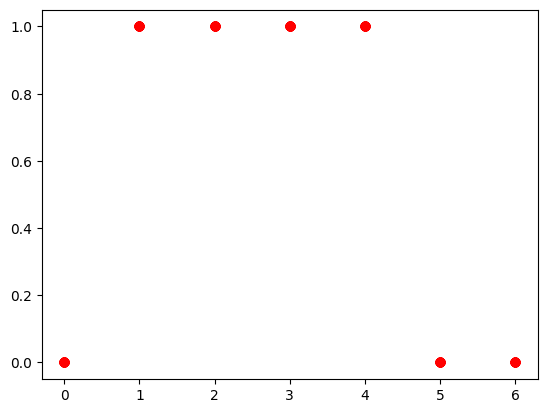

In [11]:
plt.scatter(X[:,0], best_variation.collection[0].predict(X) > 0, color='red', alpha=0.5)

In [184]:
def f_test(x):
    return 100 + 10 * x[0] + 20 * x[1] - 0.5 * (x[0] - 2.5)**2

In [33]:
X_test = X[best_variation.collection[0].predict(X) > 0]
y_test = y[best_variation.collection[0].predict(X) > 0]

rmse(f_test(X_test.T),y_test)

NameError: name 'f_test' is not defined

In [197]:
new_S0 = train_GP(X, y, best_variation.collection[0].predict(X) > 0, 
                        GP_elite_tree=best_variation.SPECIALISTS['S_0'], verbose=1, seed=0, iter_GP=1000, pp_GP=20, md_GP=9)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |    div (var)    |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.123      |       None      |      0.011      |        67       |      4.860      |       103       |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
|       test      |        1        |      0.123      |       None      |      0.054      

KeyboardInterrupt: 

In [37]:
def f8(x):
    # x[0]: day, x[1]: promotion intensity
    if x[0] < 5:  # Weekdays
        # Quadratic bump: (day-2.5)^2 gives a bump around the middle of the week.
        return 100 + 10 * x[0] + 20 * x[1] - 0.5 * (x[0] - 2.5)**2
    else:         # Weekends
        # Different linear and quadratic effect for weekend days.
        return 150 + 5 * x[0] + 15 * x[1] + 0.4 * (x[0] - 5)**2

In [12]:
test_X = X[(best_variation.collection[0].predict(X) >= 0)]
test_y = y[(best_variation.collection[0].predict(X) >= 0)] 
print(rmse(best_variation.SPECIALISTS['S_0'].predict(test_X), test_y))

0.24452917048568523


In [13]:
calculate_specialist_rmse(best_variation, X, y)

{'S_0': (np.int64(285), np.float64(0.24452917048568523)),
 'S_1': (np.int64(215), np.float64(0.18340075131217107))}

In [36]:
masks = get_specialist_masks(best_variation.collection, X)

s0_new = train_GP(X, y, masks['S_0'],
                        # GP_elite_tree=best_variation.SPECIALISTS['S_0'], 
                        verbose=1, seed=0, iter_GP=1000, pp_GP=20, md_GP=7)    

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |    div (var)    |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      55.633     |       None      |      0.004      |        7        |      4.220      |       101       |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
|       test      |        1        |      30.913     |       None      |      0.011      

OTHER 
_______________________________________

In [ ]:
X, y, mask, mask_conditions = load_synthetic8()
root_indices = np.arange(len(y))
mask_ids = [np.where(submask)[0] for submask in mask]

# Scatterplot 
plt.scatter(X[:, 0], y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatterplot of Data Points')
plt.show()

verbose=1

mask_ids = [np.where(submask)[0] for submask in mask]
root = PiecewiseNode(X=X, y=y, indices=root_indices, mask=mask_ids,
                     config=config, params=params, depth=0, seed=120)

root.fit_and_evaluate(verbose=verbose)
print('Current_silhouette:', round(calculate_silhouette(root),2))

grow(root, verbose=verbose)

for id in children_ids(root): 
    indices = root[id].indices
    print(f'Correspondance {id}: {[np.intersect1d(submask, indices).shape[0] for submask in mask_ids]}')

best_variation = simplification_ensemble(root, X, y, verbose=True)

clear_output(wait=True)
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 0], best_variation.predict(X), color='red', alpha=0.5) 
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatterplot of Data Points')
plt.show()

In [ ]:
masks_pred = get_specialist_masks(best_variation.collection, X)
masks_pred = [np.where(submask)[0] for submask in masks_pred.values()]
for i, mask in enumerate(masks_pred):
    print(f'Correspondance {i}: {[np.intersect1d(submask, mask).shape[0] for submask in mask_ids]}')

### Other 
____________________________

In [ ]:
seed = 10

X, y = datasets[10]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.25)

params = GPParameters(pop_size=100, n_iter=1000, max_depth=7, init_depth=3,
                      selector='dalex', p_xo=0.8, down_sampling=1)

ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='e_lexicase', population=spec_pop,
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=2000, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=5, depth_condition=6, down_sampling=0.25,
                                test_elite=True, timeout=200)

In [ ]:
seed = 10

x7, y7, mask7 = load_synthetic7(n=800, seed=0, noise=0)
train_indices, test_indices = train_test_split(x7, y7, p_test=0.2, indices_only=True, seed=seed)
X_train = x7[train_indices]
y_train = y7[train_indices]
X_test = x7[test_indices]
y_test = y7[test_indices]
mask_train = [m[train_indices] for m in mask7]

log_specialist = LogSpecialist(mask_train, X_train, y_train)

params = GPParameters(pop_size=100, n_iter=100, max_depth=7, init_depth=3,
                      selector='dalex', p_xo=0.8, down_sampling=1, callbacks=[log_specialist])

ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='dalex', 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=500, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                test_elite=True, timeout=200)

log_specialist.plot_specialist_fitnesses()

In [ ]:
masks_specialist = get_specialist_masks(ensemble_tree.collection, X_train)
print(compute_composite_mask_distance(masks_specialist.values(), mask_train, lambda_penalty=1))

GP RUN

In [ ]:
X, y = datasets[0]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)
seed = 10

elite, gp_pop = gp(X_train=X_train, y_train=y_train, full_return=True, test_elite=False, dataset_name='',
                       selector='tournament', n_iter=100, pop_size=100, 
                       max_depth=4, init_depth=3, p_xo=0.8, down_sampling=0.8, seed=seed, verbose=0,
                       )

In [ ]:
X, y = datasets[2]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)
# X_train = MinMaxScaler().fit_transform(X_train)
# X_test = MinMaxScaler().fit_transform(X_test)
# y_train = MinMaxScaler().fit_transform(y_train.reshape(-1, 1)).ravel()
# y_test = MinMaxScaler().fit_transform(y_test.reshape(-1, 1)).ravel()

# X = np.random.rand(20, 2)
# y = np.random.rand(20)
# X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)

seed = 2

# agelog = LogAge()
# divlog = LogDiversity()
# early_stop = EarlyStopping_train(patience=2500)

example_tree, population = slim(X_train=X_train, y_train=y_train,
                    dataset_name='test', test_elite=False, slim_version='SLIM*ABS', # initializer='simple',
                    max_depth=15, init_depth=5, pop_size=100, n_iter=1000, seed=seed, verbose=1,
                    p_inflate=0.3, p_struct=0.3, n_cases=100,
                    prob_const=0.2, n_elites=1, selector='dalex', 
                    decay_rate=0.2, p_xo=0, p_struct_xo=0, prob_terminal=0.7,
                    # callbacks=[agelog, divlog, early_stop], 
                    mode='exp', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

for ind in population.population:
    ind.version = example_tree.version
    ind.train_semantics = ind.predict(X_train)
    ind.test_semantics = ind.predict(X_test)

FUNCTIONS = example_tree.collection[0].FUNCTIONS
TERMINALS = example_tree.collection[0].TERMINALS
CONSTANTS = example_tree.collection[0].CONSTANTS
SPECIALISTS = {f'S_{i}' : ind for i, ind in enumerate(population.population) if i<5}
Tree.FUNCTIONS = FUNCTIONS
Tree.TERMINALS = TERMINALS
Tree.CONSTANTS = CONSTANTS
Tree.SPECIALISTS = SPECIALISTS
Condition.FUNCTIONS = FUNCTIONS
Condition.TERMINALS = TERMINALS
Condition.CONSTANTS = CONSTANTS

In [ ]:
collection = create_random_tree(2, 2, FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS)
tree = Tree(collection)
print(tree.collection)

In [ ]:
pop = initializer(pop_size=100, 
            depth_condition=4, 
            max_depth=4, 
            FUNCTIONS=FUNCTIONS, 
            TERMINALS=TERMINALS, 
            CONSTANTS=CONSTANTS,
            SPECIALISTS=SPECIALISTS,
            p_c=0.3, 
            p_t=0.7, 
            p_specialist=0.5,
            )

pop = Population([Tree(struc) for struc in pop])
pop.calculate_semantics(X_train)
pop.evaluate(y_train, testing=False)

In [ ]:
op = mutator(FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS, depth_condition=4, max_depth=4, p_c=0.3, p_t=0.5, decay_rate=0.2)

In [ ]:
mdepth, mfit, mtotalnodes = [], [], []

population = pop

for it in range(50): 
    mean_depth = np.mean([i.depth for i in population.population])
    mean_total_nodes = np.mean([i.total_nodes for i in population.population])
    mean_fit = np.mean(population.fit)
    mdepth.append(mean_depth)
    mfit.append(mean_fit)
    mtotalnodes.append(mean_total_nodes)
    
    offs_pop = []
    for _ in range(100):
        p = tournament_selection_min(2)(population)
        o = op(p)
        offs_pop.append(o)
    
    population = Population(offs_pop)
    population.calculate_semantics(X_train)
    population.evaluate(y_train)

In [ ]:
mfit

In [ ]:
id1, id2 = pop[85], pop[60]
print(id1.depth, id2.depth)
o1, o2 = homologus_xo(id1, id2, 4)
print(o1.depth, o2.depth)

In [ ]:
depths = {}
id1 = pop[60]
for _ in range(10000):
    o1 = op(id1)
    depth = o1.depth 
    if depth not in depths: 
        depths[depth] = 1
    else: 
        depths[depth] += 1

In [ ]:
id1 = pop[60]
print(id1.depth)
o1 = op(id1)
print(o1.depth, id1 == o1)

In [ ]:
o1.collection

In [ ]:
id1.collection

In [ ]:
idx_lev1 = get_indices_with_levels(i1)[1:]
idx_lev2 = get_indices_with_levels(i2)[1:]
idx_lev3 = get_indices_with_levels(i3)[1:]

print(idx_lev1)
print(idx_lev2)
print(idx_lev3)

In [ ]:
max_depth1 = max([i for _,i in idx_lev1])
max_depth2 = max([i for _,i in idx_lev2])
max_depth3 = max([i for _,i in idx_lev3])

In [ ]:
chosen_level1 = np.random.randint(1, max_depth1+1)
chosen_level2 = np.random.randint(1, max_depth2+1)
chosen_level3 = np.random.randint(1, max_depth3+1)

In [ ]:
chosen_level1 = np.random.randint(1, max_depth1+1)
chosen_level2 = np.random.randint(1, max_depth2+1)
chosen_level3 = np.random.randint(1, max_depth3+1)

path1 = random.choice(get_indices_with_levels(i1)[1:])[0]
path2 = random.choice(get_indices_with_levels(i2)[1:])[0]
path3 = random.choice(get_indices_with_levels(i3)[1:])[0]

sub1 = get_subtree(i1, path1)
sub2 = get_subtree(i2, path2)
sub3 = get_subtree(i3, path3)

print(sub1) 
print(sub2)
print(sub3)

In [ ]:
replace_subtree(i1, )

In [ ]:
set([depth for _, depth in idx_lev2])

In [ ]:
level = random.choices(list(set([depth for _, depth in idx_lev2])))[0]
idx = random.choice([i for i, depth in idx_lev2 if depth == level])
print(idx)

In [ ]:
level = random.choices(list(set([depth for _, depth in idx_lev2])))[0]
idx = random.choice([i for i, depth in idx_lev2 if depth == level])

# Get the subtree of the tree.
subtree = get_subtree(i2, idx)
print(subtree)

In [ ]:
idx_lev1 = get_indices_with_levels(i2)[1:]
idx, level = uniform_level_choice(idx_lev1)
print(idx, level)
print(get_subtree(i2, idx))

In [ ]:
idx_lev1, idx_lev2 = get_indices_with_levels(i2)[1:], get_indices_with_levels(i3)[1:]
idx, depth = uniform_level_choice(idx_lev1)

In [ ]:
[indices for indices, depth in idx_lev1 if depth == 2]

In [ ]:
def uniform_level_choice(idx_lev):
    level = random.choices(list(set([depth for _, depth in idx_lev])))[0]
    idx = random.choice([i for i, depth in idx_lev if depth == level])
    return idx, level

def homologus_xo(ind1, ind2):    
    ind1, ind2 = ind1.collection, ind2.collection

    # Both are terminals; no crossover is possible.
    if isinstance(ind1, str) and isinstance(ind2, str):
        return ind1, ind2
    
    # One of them is a terminal; the terminal of one is replaced by the tree of the other. No depth restriction.
    elif isinstance(ind1, tuple) and isinstance(ind2, str):
        idx_lev1 = get_indices_with_levels(ind1)[1:]
        idx, _ = uniform_level_choice(idx_lev1)
        offs1 = get_subtree(ind1, idx)
        offs2 = replace_subtree(ind1, idx, ind2)
        
    elif isinstance(ind1, str) and isinstance(ind2, tuple):
        idx_lev2 = get_indices_with_levels(ind2)[1:]
        idx, _ = uniform_level_choice(idx_lev2)
        offs1 = get_subtree(ind2, idx)
        offs2 = replace_subtree(ind2, idx, ind1)

    # Both are tuples 
    else: 
        idx_lev1, idx_lev2 = get_indices_with_levels(ind1)[1:], get_indices_with_levels(ind2)[1:]
        idx_1, depth = uniform_level_choice(idx_lev1)
        same_depth = [indices for indices, d in idx_lev2 if d == depth]
        if same_depth: 
            idx_2 = random.choice(same_depth)
        else: 
            # The second parent has depth smaller than the first parent.
            # Uniform_level_choice isnt used to favor indices closer to depth (same functionality)
            idx_2 = random.choice([indices for indices, d in idx_lev2 if d < depth]) 
        
        tree_1 = get_subtree(ind1, idx_1)
        tree_2 = get_subtree(ind2, idx_2)
        offs1 = replace_subtree(ind1, idx_1, tree_2)
        offs2 = replace_subtree(ind2, idx_2, tree_1)

    return Tree(offs1), Tree(offs2)

In [ ]:
a,b = crossover(pop[60],pop[33])

In [ ]:
a.collection

In [ ]:
b.collection

In [ ]:
pop[60].collection

In [ ]:
pop[33].collection

### ------------------------------------------------------------------------------------------------

In [ ]:
struc = create_random_tree(3, 3, FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS, p_specialist=0.7, p_t=0.7)
print(struc)

In [ ]:
struc = create_random_tree(2, 1, FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS)
tree = Tree(struc)
tree.evaluate(rmse, X_train, y_train, testing=False)
tree.evaluate(rmse, X_test, y_test, testing=True)   
tree.print_tree_representation()
print('------------------/-----------------')
print('Train RMSE (ensemble):', tree.fitness)
print('Test RMSE (ensemble):', tree.test_fitness)
print('Train RMSE (individual):', rmse(example_tree.predict(X_train), y_train))
print('Test RMSE (individual):', rmse(example_tree.predict(X_test), y_test))
print('------------------/-----------------')
print('Nodes:', tree.nodes_count)   
print('Total Nodes:', tree.total_nodes)


In [ ]:
from slim_gsgp_lib_np.config.multi_slim_config import * 
slim_params = SlimParameters()